In [6]:
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data Pre-Processing functions

NOTE TO SELF: Use boolean masking to cut dataframes whenever possible -> much faster than pd.drop

In [18]:
def process_data(data_path, del_cols=[], cuts=True):
    """
    This functions reads and pre-processes all the data in the chosen data_path with pandas
    
    data_path -> string: the path of the data to be acquired and pre-processed\n
    del_cols -> [string]: all columns to be deleted from the dataframe\n
    btag_cols -> [string]: list of columns referring to btag count\n
    lepton_cols -> [string]: list of columns referring to lepton count\n
    cut -> bool: whether or not cuts are to be applied to the data
    
    return -> pandas dataframe: pre-processed data
    """
    
    # Initializing variables
    data = []
    total_drop, total_len = 0, 0
    files = glob(data_path + "/*.csv")
    files += glob(data_path + "/*.h5")
    
    # Collect all data from path
    for file in tqdm(files, total=len(files), desc="Preprocessing Data"):
        # Read sample
        if file.endswith(".csv"): df = pd.read_csv(file)
        elif file_format == "h5": df = pd.read_hdf(file)
        else: raise ValueError("Unrecognized file format")
            
        # Sort indices
        df.sort_index(inplace=True)
        
        # Apply cuts
        sample = file.split("/")[-1].split(".")[0]
        if cuts:
            len_inc = df.shape[0]
            total_len += len_inc
            df = df[df["Electron_Multi"] + df["Muon_Multi"] > 1] # At least 2 leptons
            df = df[df["FatJet_Multi"] > 1] # At least 1 FatJet
            tqdm.write(f" Sample: {sample} | Original Size: {len_inc} | Drop_Ratio: {(len_inc - df.shape[0])/len_inc:.3f}")
            total_drop += len_inc - df.shape[0]
        
        # Delete columns
        df.drop([col for col in del_cols if col in df], axis=1, inplace=True)
        
        # Calculate gen_weights
        df["gen_xsec"] = df["gen_xsec"].mean() / df.shape[0]
        df.rename(columns={"gen_xsec":"gen_weights"}, inplace=True)
        
        # Add sample and label columns
        if file.split("/")[-2] == "dileptonic": df["Label"] = 0
        elif file.split("/")[-2] == "sm_gluon_vlq": df["Label"] = 1
        else: raise ValueError("Unrecognized data folder")
        df["Sample"] = sample
        
        data.append(df)
        
    # Concatenate data
    if len(data) > 1: data = pd.concat(data)
    else: data = data[0]
        
    if cuts: print(f"Total Drop Ratio: {total_drop/total_len:.3f}")
        
    return data

# Cut Testing

In [ ]:
data_path = "data/dileptonic"
uncut_bkgd = process_data(data_path, del_cols, cuts=False)

In [ ]:
data_path = "data/sm_gluon_vlq"
uncut_vlq = process_data(data_path, del_cols, btag_cols, lepton_cols)

In [ ]:
# Testing cut ratio
vlq_ratio = uncut_vlq[uncut_vlq["Electron_Multi"] + uncut_vlq["Muon_Multi"] > 1]
vlq_ratio = vlq_ratio[vlq_ratio["FatJet_Multi"] > 1].shape[0] / uncut_vlq.shape[0]
bkgd_ratio = uncut_bkgd[uncut_bkgd["Electron_Multi"] + uncut_bkgd["Muon_Multi"] > 1]
bkgd_ratio = bkgd_ratio[bkgd_ratio["FatJet_Multi"] > 1].shape[0] / uncut_bkgd.shape[0]
print(vlq_ratio, bkgd_ratio)
print(vlq_ratio / bkgd_ratio)

In [ ]:
data_path = "data/sm_gluon_vlq"
vlq = process_data(data_path, del_cols, btag_cols, lepton_cols)

In [ ]:
# Verify ScalarHT_HT distribution variation
hist_min = min(vlq["ScalarHT_HT"].min(), uncut_vlq["ScalarHT_HT"].min())
hist_max = max(vlq["ScalarHT_HT"].max(), uncut_vlq["ScalarHT_HT"].max())
hist_range = hist_min, hist_max

plt.title("ScalarHT_HT Distributions")
plt.hist(vlq["ScalarHT_HT"], bins=50, label="vlq", range=hist_range, weights=vlq["gen_weights"], histtype="step")
plt.hist(uncut_vlq["ScalarHT_HT"], bins=50, label="uncut_vlq", range=hist_range, weights=uncut_vlq["gen_weights"], histtype="step")
plt.yscale("log")
plt.legend()
plt.savefig("2L_vs_2L_and_1FJ_cut.png", dpi=800)
plt.show()

# Import Data

In [8]:
# Delete columns list
del_cols = ["gen_decay1", "gen_decay2", "gen_sample", "gen_filter", "gen_decay_filter", "MissingET_Eta"]

In [9]:
# PreProcess bkgd data
data_path = "data/dileptonic"
bkgd = process_data(data_path, del_cols)
bkgd

Preprocessing Data:   6%|▌         | 1/18 [00:00<00:07,  2.17it/s]

 Sample: ttbarZ_2L | Original Size: 100000 | Drop_Ratio: 0.902


Preprocessing Data:  11%|█         | 2/18 [00:14<01:13,  4.58s/it]

 Sample: Zbj_2L | Original Size: 4000000 | Drop_Ratio: 0.995


Preprocessing Data:  17%|█▋        | 3/18 [00:26<01:43,  6.89s/it]

 Sample: Zbb_2L | Original Size: 4000000 | Drop_Ratio: 0.999


Preprocessing Data:  22%|██▏       | 4/18 [00:40<02:06,  9.03s/it]

 Sample: Zjj_2L | Original Size: 4000000 | Drop_Ratio: 0.994


Preprocessing Data:  28%|██▊       | 5/18 [00:42<01:28,  6.84s/it]

 Sample: ZZ_2L | Original Size: 500000 | Drop_Ratio: 0.993


Preprocessing Data:  33%|███▎      | 6/18 [00:42<00:58,  4.86s/it]

 Sample: ttbarZ_2L_test | Original Size: 50000 | Drop_Ratio: 0.902


Preprocessing Data:  39%|███▉      | 7/18 [00:43<00:38,  3.46s/it]

 Sample: topZj_2L_test | Original Size: 50000 | Drop_Ratio: 0.962


Preprocessing Data:  44%|████▍     | 8/18 [00:43<00:24,  2.49s/it]

 Sample: topWZ_2L | Original Size: 50000 | Drop_Ratio: 0.893


Preprocessing Data:  50%|█████     | 9/18 [00:43<00:16,  1.81s/it]

 Sample: topZj_2L_train | Original Size: 50000 | Drop_Ratio: 0.964


Preprocessing Data:  56%|█████▌    | 10/18 [00:43<00:11,  1.39s/it]

 Sample: ttbarW_2L | Original Size: 100000 | Drop_Ratio: 0.972


Preprocessing Data:  61%|██████    | 11/18 [00:44<00:07,  1.10s/it]

 Sample: topZj_2L | Original Size: 100000 | Drop_Ratio: 0.963


Preprocessing Data:  67%|██████▋   | 12/18 [00:46<00:07,  1.29s/it]

 Sample: WZ_2L | Original Size: 500000 | Drop_Ratio: 0.992


Preprocessing Data:  72%|███████▏  | 13/18 [01:01<00:27,  5.45s/it]

 Sample: ttbarb_2L | Original Size: 3899999 | Drop_Ratio: 0.993


Preprocessing Data:  78%|███████▊  | 14/18 [01:01<00:15,  3.88s/it]

 Sample: ttbarZ_2L_train | Original Size: 50000 | Drop_Ratio: 0.902


Preprocessing Data:  83%|████████▎ | 15/18 [01:03<00:10,  3.36s/it]

 Sample: ttbarH_2L | Original Size: 500000 | Drop_Ratio: 0.969


Preprocessing Data:  89%|████████▉ | 16/18 [01:05<00:05,  2.91s/it]

 Sample: ttbar_2L | Original Size: 500000 | Drop_Ratio: 0.991


Preprocessing Data:  94%|█████████▍| 17/18 [01:21<00:06,  6.81s/it]

 Sample: ttbarj_2L | Original Size: 4000000 | Drop_Ratio: 0.987


Preprocessing Data: 100%|██████████| 18/18 [01:22<00:00,  4.61s/it]

 Sample: WW_2L | Original Size: 500000 | Drop_Ratio: 0.997
Total Drop Ratio: 0.992


,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,gen_weights,Label,Sample
27,2,315.526428,210.032394,0.000000,0.000000,0.0,79.493019,69.408371,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,88.304909,1.464204,784.078552,0.000004,0,ttbarZ_2L
28,2,339.583130,219.172821,0.000000,0.000000,0.0,116.564987,78.811958,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,99.853302,0.038497,775.420654,0.000004,0,ttbarZ_2L
29,4,467.367920,325.581726,263.518768,245.053696,0.0,148.663666,92.171494,42.070469,36.246201,...,0.000000,0.000000,0.000000,0.000000,81.364784,-1.312568,1463.551270,0.000004,0,ttbarZ_2L
32,2,296.354340,294.816193,0.000000,0.000000,0.0,22.605494,50.957157,0.000000,0.000000,...,1.419246,1.573958,1.106225,0.838509,143.709824,1.469797,825.930359,0.000004,0,ttbarZ_2L
44,2,319.661041,279.680908,0.000000,0.000000,0.0,78.290215,111.059021,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,14.954485,1.378663,876.833496,0.000004,0,ttbarZ_2L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499383,2,562.090515,406.163391,0.000000,0.000000,0.0,33.144203,32.881790,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,158.903229,-1.832084,989.765320,0.002525,0,WW_2L
499720,2,297.991119,216.625351,0.000000,0.000000,0.0,122.802528,0.000004,0.000000,0.000000,...,-0.388207,-0.442014,0.494916,-2.443376,90.066765,0.922439,516.766602,0.002525,0,WW_2L
499778,2,445.022675,322.059509,0.000000,0.000000,0.0,43.183895,0.000005,0.000000,0.000000,...,-0.231364,0.000000,2.371314,0.000000,117.803192,2.502448,845.329529,0.002525,0,WW_2L
499884,2,292.791809,240.076736,0.000000,0.000000,0.0,7.178124,71.778534,0.000000,0.000000,...,1.316574,0.000000,1.245588,0.000000,48.155449,1.515914,537.060669,0.002525,0,WW_2L


In [19]:
#Pre-Process VLQ data
data_path = "data/sm_gluon_vlq"
vlq = process_data(data_path, del_cols)
vlq

Preprocessing Data:  14%|█▍        | 1/7 [00:01<00:07,  1.27s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1200_test | Original Size: 250000 | Drop_Ratio: 0.940


Preprocessing Data:  29%|██▊       | 2/7 [00:02<00:06,  1.27s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1200_train | Original Size: 250000 | Drop_Ratio: 0.941


Preprocessing Data:  43%|████▎     | 3/7 [00:03<00:05,  1.28s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1400_train | Original Size: 250000 | Drop_Ratio: 0.942


Preprocessing Data:  57%|█████▋    | 4/7 [00:13<00:11,  3.74s/it]

 Sample: smg | Original Size: 1900000 | Drop_Ratio: 0.939


Preprocessing Data:  71%|███████▏  | 5/7 [00:14<00:05,  3.00s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1000_test | Original Size: 250000 | Drop_Ratio: 0.938


Preprocessing Data:  86%|████████▌ | 6/7 [00:15<00:02,  2.47s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1000_train | Original Size: 250000 | Drop_Ratio: 0.939


Preprocessing Data: 100%|██████████| 7/7 [00:17<00:00,  2.44s/it]

 Sample: mch45_HG_13TeV_wohg_HQ1400_test | Original Size: 250000 | Drop_Ratio: 0.943
Total Drop Ratio: 0.940


,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,gen_weights,Label,Sample
8,4,679.288574,637.196655,575.872986,465.836670,0.000000,237.651794,84.461655,95.651817,168.446136,...,1.093419,0.041427,-2.275989,3.101779,59.826347,-1.571166,2314.953613,5.616493e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
72,3,722.096008,712.639893,292.318909,0.000000,0.000000,95.335800,268.030182,64.672127,0.000000,...,-1.049473,0.000000,-0.830934,0.000000,854.150696,-1.032758,1928.374756,5.616493e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
82,3,630.115234,305.956909,283.162201,0.000000,0.000000,114.620941,91.065170,96.998154,0.000000,...,0.621256,0.000000,1.390831,0.000000,701.605103,-2.040793,1302.086548,5.616493e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
115,3,615.789185,381.363312,289.322754,0.000000,0.000000,157.678223,123.475723,64.592873,0.000000,...,-0.639307,0.000000,2.483285,0.000000,377.781586,1.851912,1421.504761,5.616493e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
118,2,603.029968,528.326599,0.000000,0.000000,0.000000,96.925636,119.643799,0.000000,0.000000,...,0.418918,0.109304,2.743015,2.692961,185.340561,-0.824091,1783.073975,5.616493e-07,1,mch45_HG_13TeV_wohg_HQ1200_test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249910,4,666.686401,607.264709,450.049072,391.603912,0.000000,115.184601,179.727097,114.864006,64.223465,...,0.000000,0.000000,0.000000,0.000000,112.573494,-2.934912,2303.999756,1.804517e-07,1,mch45_HG_13TeV_wohg_HQ1400_test
249918,4,928.090820,700.795898,401.137665,232.056839,0.000000,346.194672,102.790993,94.033356,23.929482,...,0.000000,0.000000,0.000000,0.000000,365.781525,-2.217049,2508.777588,1.804517e-07,1,mch45_HG_13TeV_wohg_HQ1400_test
249942,2,1385.916504,1031.829224,0.000000,0.000000,0.000000,139.179977,158.596802,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,226.095474,-0.110796,2874.203857,1.804517e-07,1,mch45_HG_13TeV_wohg_HQ1400_test
249974,5,967.123413,555.906433,533.325867,327.264191,263.725922,173.991745,96.630959,131.944000,63.603821,...,0.000000,0.000000,0.000000,0.000000,329.906006,0.181167,2831.758057,1.804517e-07,1,mch45_HG_13TeV_wohg_HQ1400_test


In [20]:
bkgd.describe()

,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron2_PT,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,gen_weights,Label
count,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,...,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.000000,193303.0
mean,2.128110,339.671813,268.350574,28.973949,2.569942,0.175146,77.237573,60.200663,6.152909,0.515354,...,19.477892,0.001621,0.000891,-0.001484,0.002390,79.272815,-0.004636,853.000883,0.002446,0.0
std,0.369723,113.115834,78.654032,81.849727,24.933798,6.363602,43.293426,36.733849,20.007821,5.653394,...,42.351922,0.765750,0.555790,1.359917,0.945178,70.852835,1.815033,254.341797,0.005197,0.0
min,2.000000,200.219269,200.000000,0.000000,0.000000,0.000000,-0.000053,-0.000031,-0.000022,-0.000011,...,0.000000,-2.499769,-2.499928,-3.141227,-3.141329,0.056328,-3.141583,309.116425,0.000001,0.0
25%,2.000000,262.260605,217.427872,0.000000,0.000000,0.000000,40.712770,30.223483,0.000000,0.000000,...,0.000000,-0.148044,0.000000,-0.339008,0.000000,29.049857,-1.581987,678.038849,0.000025,0.0
50%,2.000000,311.187653,243.406723,0.000000,0.000000,0.000000,79.531601,55.197495,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,58.999470,0.002333,806.685059,0.000530,0.0
75%,2.000000,383.790131,291.170807,0.000000,0.000000,0.000000,102.345623,86.388321,0.000000,0.000000,...,18.077967,0.159261,0.000000,0.339321,0.000000,107.541634,1.567748,970.307190,0.001002,0.0
max,6.000000,1901.563477,1671.708862,968.598022,530.689697,336.192627,524.394775,505.283325,305.244202,178.961639,...,649.593811,2.499553,2.498734,3.141501,3.141414,1030.364014,3.141541,3903.838379,0.029542,0.0


In [21]:
vlq.describe()

,FatJet_Multi,FatJet1_PT,FatJet2_PT,FatJet3_PT,FatJet4_PT,FatJet5_PT,FatJet1_Mass,FatJet2_Mass,FatJet3_Mass,FatJet4_Mass,...,Electron2_PT,Electron1_Eta,Electron2_Eta,Electron1_Phi,Electron2_Phi,MissingET_MET,MissingET_Phi,ScalarHT_HT,gen_weights,Label
count,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,...,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,205536.000000,2.055360e+05,205536.0
mean,3.133432,694.687261,506.635654,277.880469,96.113805,11.325154,146.591222,114.300088,66.213135,22.109254,...,40.577671,-0.000426,-0.000467,0.001914,-0.002662,238.008370,-0.000585,1817.300415,5.644880e-07,1.0
std,0.830962,241.053470,195.679681,187.167583,147.722005,54.622885,76.081017,57.152617,53.706410,38.438395,...,82.143227,0.693450,0.523660,1.366149,1.021680,186.956118,1.814640,549.417149,6.172379e-07,0.0
min,2.000000,200.708145,200.000870,0.000000,0.000000,0.000000,-0.000031,-0.000053,-0.000026,-0.000022,...,0.000000,-2.499892,-2.498925,-3.141591,-3.141575,0.025636,-3.141592,424.210327,1.773451e-07,1.0
25%,3.000000,524.364487,367.499496,205.508778,0.000000,0.000000,95.964296,83.029293,10.610544,0.000000,...,0.000000,-0.152401,0.000000,-0.370466,0.000000,97.709469,-1.573876,1426.947479,2.780911e-07,1.0
50%,3.000000,655.761871,472.742783,296.849991,0.000000,0.000000,126.073280,103.368092,70.298485,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,191.438072,-0.006473,1744.865784,2.780911e-07,1.0
75%,4.000000,822.074615,607.822098,397.605217,229.609512,0.000000,176.474823,142.025646,99.550213,35.329542,...,43.567314,0.145814,0.000000,0.390309,0.000000,329.067711,1.577456,2121.958191,5.616493e-07,1.0
max,8.000000,2879.625977,2635.632812,1336.856812,1062.891113,814.843140,1065.849609,851.648132,543.557068,337.304260,...,990.969849,2.499868,2.498529,3.141592,3.141577,2279.300049,3.141547,6155.838379,2.033365e-06,1.0


## Save Data

In [22]:
bkgd.to_hdf("data/preprocessed/bkgd.h5", key="bkgd")
vlq.to_hdf("data/preprocessed/vlq.h5", key="vlq")

# Plots

Plotting: 100%|██████████| 72/72 [02:11<00:00,  1.83s/it]


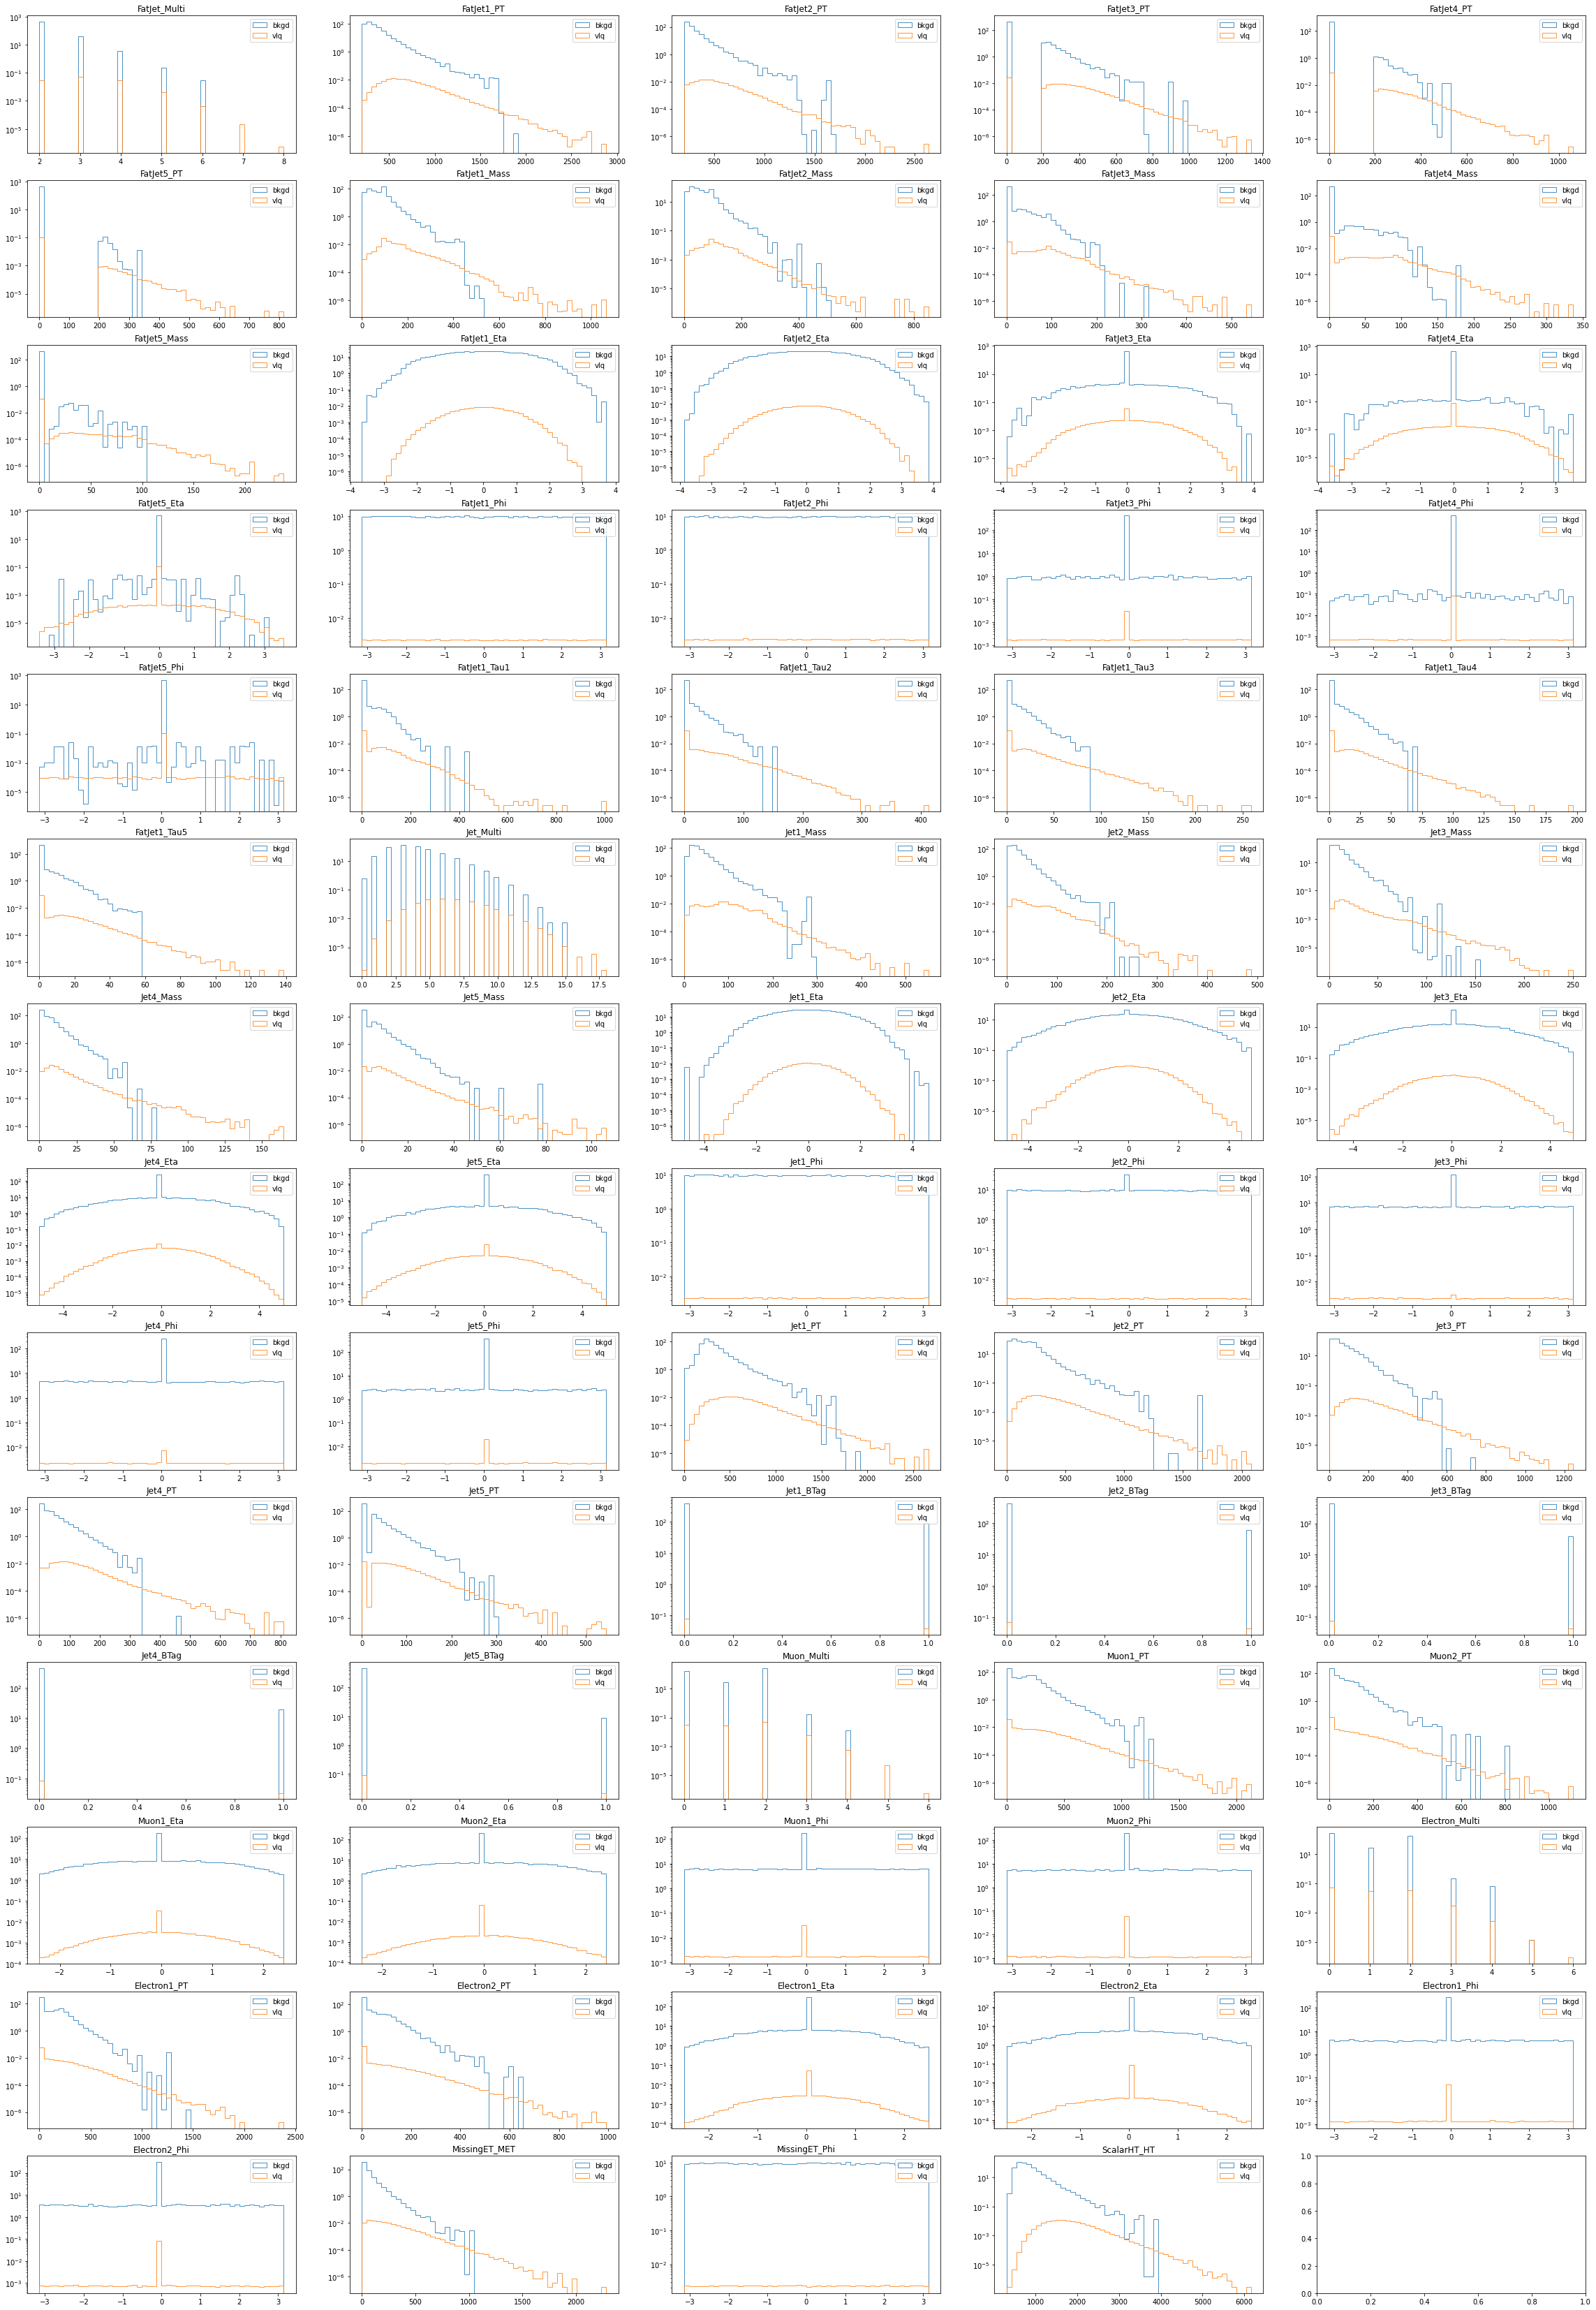

In [23]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(bkgd.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
ignore_cols = ["gen_weights", "Label", "Sample"]
for i, column in tqdm(enumerate(bkgd.columns), total=len(list(bkgd.columns)), desc="Plotting"):
    if vlq.columns[i] not in ignore_cols:
        # Define histogram range
        hist_min = min(vlq[column].min(), bkgd[column].min())
        hist_max = max(vlq[column].max(), bkgd[column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(vlq.columns[i])
        axs[row, col].hist(bkgd[column], bins=50, label="bkgd", alpha=0.8, range=hist_range,
                           weights=bkgd["gen_weights"], histtype='step')
        axs[row, col].hist(vlq[column], bins=50, label="vlq", alpha=0.8, range=hist_range,
                           weights=vlq["gen_weights"], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.show()

## Plotting VLQ before and after cuts

In [ ]:
data_path = "data/sm_gluon_vlq"
uncut_vlq = process_data(data_path, del_cols, btag_cols, lepton_cols, False)
# vlq = process_data(data_path, del_cols, btag_cols, lepton_cols)

In [ ]:
# Adjustment variables
num_cols, bins = 5, 50

# Create plots
num_rows = int(np.ceil((len(list(vlq.columns)) - 2) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))

# Iterate and plot the data
ignore_cols = ["gen_weights", "Label", "Sample"]
for i, column in tqdm(enumerate(vlq.columns), total=len(list(vlq.columns)), desc="Plotting"):
    if vlq.columns[i] not in ignore_cols:
        # Define histogram range
        hist_min = min(vlq[column].min(), uncut_vlq[column].min())
        hist_max = max(vlq[column].max(), uncut_vlq[column].max())
        hist_range = (hist_min, hist_max)

        # Plot data
        row, col = int(i/num_cols), i%num_cols
        axs[row, col].set_title(vlq.columns[i])
        axs[row, col].hist(uncut_vlq[column], bins=50, label="uncut_vlq", alpha=0.8, range=hist_range,
                           weights=uncut_vlq["gen_weights"], histtype='step')
        axs[row, col].hist(vlq[column], bins=50, label="vlq", alpha=0.8, range=hist_range,
                           weights=vlq["gen_weights"], histtype='step')
        axs[row, col].set_yscale("log")
        axs[row, col].legend()

plt.show()